# Ensemble of the best models: ward, kmeans, clara_opt

Try kmeans + ward; kmeans + clara_opt; ward + clara_opt; kmeans + ward + clara 

In [1]:
import pandas as pd
from sklearn.cluster import KMeans,  AgglomerativeClustering
from sklearn_extra.cluster import CLARA
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
df = pd.read_csv('../2_models/with_raw_data/solar/pca_df.csv')
subset_df = pd.read_csv('../2_models/with_raw_data/solar/df_subset.csv')

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

## K-Means + Ward Link

In [4]:
# K-Means:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

KMeans is done


In [6]:
# Gaussian Mixture:
ward = AgglomerativeClustering(linkage='ward', distance_threshold=0.01, n_clusters=None)
ward.fit(np.array(df))

# Cut dendrogram to obtain labels
num_clusters = 4  # Adjust as needed

# Convert the children_ attribute to a scipy hierarchical tree
linkage_matrix = np.column_stack([ward.children_, ward.distances_,
                                  np.ones_like(ward.distances_)])
# Cut the tree to obtain labels
ward_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

In [7]:
with open('results/raw_solar/ward.pickle', 'wb') as f:
    pickle.dump(ward_labels, f)
    

with open('results/raw_solar/kmeans.pickle', 'wb') as f:
    pickle.dump(kmeans, f)
kmeans_labels = kmeans.fit_predict(df)

In [8]:
with open('results/raw_solar/ward.pickle', 'rb') as f:
   ward_labels = pickle.load(f)

with open('results/raw_solar/kmeans.pickle', 'rb') as f:
   kmeans = pickle.load(f)

Using Major Voting as Ensemble Technique

In [9]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(ward_labels)))
voting_labels_kmeans_ward = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    ward_cluster = ward_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[ward_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_ward[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [10]:
df['cluster_label'] = voting_labels_kmeans_ward
df['asset_id'] = subset_df['asset_id']

In [11]:
df.to_csv('results/raw_solar/ward_kmeans.csv', index = False)

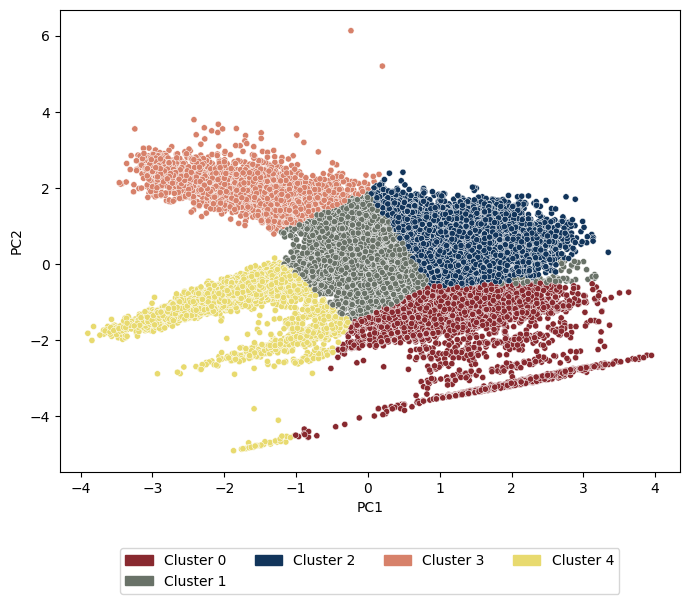

In [12]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_ward)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [13]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,0
1,0.203757,-1.467581,11,0
2,1.005381,-1.059952,11,0
3,2.111048,-0.849120,11,0
4,-0.148070,-1.640123,11,0


In [14]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,0
1,12,1.826629,-1.419172,0
2,13,-0.754270,0.041137,4
3,14,0.939960,0.034637,4
4,15,-0.538450,-0.000517,1
...,...,...,...,...
72,510,0.211749,0.019254,3
73,511,0.800390,0.061607,3
74,512,2.197902,-3.128753,3
75,513,-2.400037,2.145315,3


In [15]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 52, 58]
Cluster 1: [4, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 47, 48, 50, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [9, 10, 11, 12, 13, 15, 16, 36, 37, 38, 40, 43, 49, 51, 53, 54, 55]
Cluster 3: [39, 41, 42, 44, 72, 73, 74, 75, 76]
Cluster 4: [2, 3, 5, 14, 17]


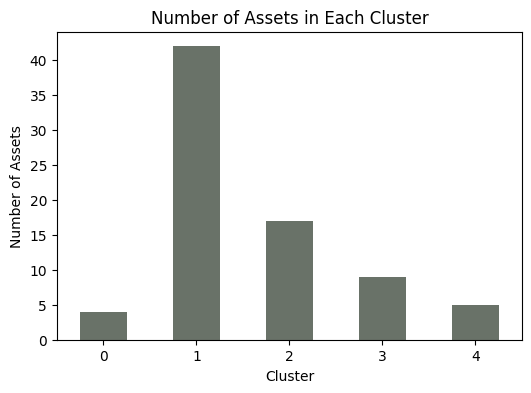

In [16]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [17]:
def dunn_index(points = np.array(df), labels = voting_labels_kmeans_ward):
    min_intercluster_distances = []
    max_intracluster_distances = []
    
    for label in np.unique(labels):
        cluster_points = points[labels == label]
        if len(cluster_points) > 1:
            intracluster_distances = pairwise_distances(cluster_points)
            max_intracluster_distances.append(np.max(intracluster_distances))
        
        for other_label in np.unique(labels):
            if label != other_label:
                other_cluster_points = points[labels == other_label]
                intercluster_distances = pairwise_distances(cluster_points, other_cluster_points)
                min_intercluster_distances.append(np.min(intercluster_distances))
    
    if len(max_intracluster_distances) == 0 or len(min_intercluster_distances) == 0:
        return 0
    
    return min(min_intercluster_distances) / max(max_intracluster_distances)


In [18]:
def xie_beni_index(points = np.array(df), labels = voting_labels_kmeans_ward):
    # Compute the total scatter
    total_scatter = np.sum(pairwise_distances(points) ** 2) / (2 * len(points))
    
    # Compute the intra-cluster scatter
    cluster_labels = np.unique(labels)
    intra_cluster_scatter = 0
    for label in cluster_labels:
        cluster_points = points[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        intra_cluster_scatter += np.sum(np.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
    intra_cluster_scatter /= len(points)
    
    return intra_cluster_scatter / total_scatter


In [19]:
# Define a function to compute evaluation metrics
def compute_metrics(points = np.array(df), labels = voting_labels_kmeans_ward):

    metrics = {}
    
    metrics['Silhouette Score'] = silhouette_score(points, labels)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(points, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(points, labels)
    metrics['Dunn Index'] = dunn_index(points, labels)
    metrics['Xie-Beni Index'] = xie_beni_index(points, labels)

    return metrics


In [20]:
# Initialize an empty list to store the results
results = []

# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_kmeans_ward)
results.append({'Model': 'ward + kmeans_opt', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [21]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,-0.089707,21.078087,237.516042,0.00001,0.000024


## K-Means + Clara with optimized parameters

In [22]:
df = df[['PC1', 'PC2']]

In [ ]:
# K-Means:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans_labels = kmeans.fit_predict(df)

print('KMeans is done')

clara = CLARA(n_clusters=5, random_state=1)
clara_labels = clara.fit_predict(df)

KMeans is done


In [ ]:
with open('results/raw_solar/clara.pickle', "wb") as f:
    pickle.dump(clara, f)

In [23]:
with open('results/raw_solar/clara.pickle', "rb") as f:
    clara = pickle.load(f)
clara_labels = clara.fit_predict(df)

In [24]:
# Voting based on cluster assignments
num_clusters = max(len(set(kmeans_labels)), len(set(clara_labels)))
voting_labels_kmeans_clara = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[clara_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_kmeans_clara[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [25]:
df['cluster_label'] = voting_labels_kmeans_clara
df['asset_id'] = subset_df['asset_id']

In [26]:
df.to_csv('results/raw_solar/clara_kmeans.csv', index = False)

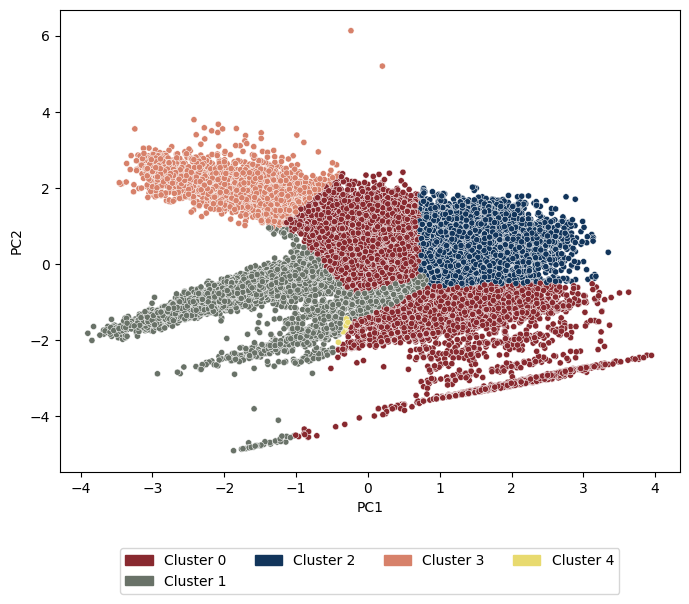

In [27]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means and CLARA')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_kmeans_clara)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [28]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,0
1,0.203757,-1.467581,11,0
2,1.005381,-1.059952,11,0
3,2.111048,-0.849120,11,0
4,-0.148070,-1.640123,11,0


In [29]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,0
1,12,1.826629,-1.419172,0
2,13,-0.754270,0.041137,1
3,14,0.939960,0.034637,1
4,15,-0.538450,-0.000517,1
...,...,...,...,...
72,510,0.211749,0.019254,0
73,511,0.800390,0.061607,3
74,512,2.197902,-3.128753,0
75,513,-2.400037,2.145315,0


In [30]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 15, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76]
Cluster 1: [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 22, 33, 46, 47, 50, 54]
Cluster 2: [9, 49, 55]
Cluster 3: [73]


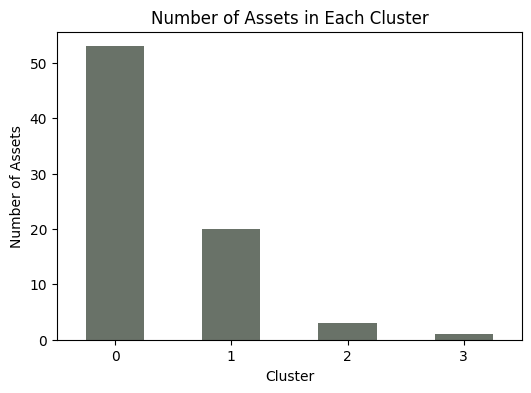

In [31]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [32]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_kmeans_clara)
results.append({'Model': 'clara + kmeans', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [33]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,-0.089707,21.078087,237.516042,0.000010,0.000024
1,clara + kmeans,-0.138677,16.197900,225.774162,0.000015,0.000024


## Ward + CLARA

In [34]:
df = df[['PC1', 'PC2']]

In [35]:
# Voting based on cluster assignments
num_clusters = max(len(set(ward_labels)), len(set(clara_labels)))
voting_labels_ward_clara = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    ward_cluster = ward_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[ward_cluster] += 1
    votes[clara_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_ward_clara[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [36]:
df['cluster_label'] = voting_labels_ward_clara
df['asset_id'] = subset_df['asset_id']

In [37]:
df.to_csv('results/raw_solar/ward_clara.csv', index = False)

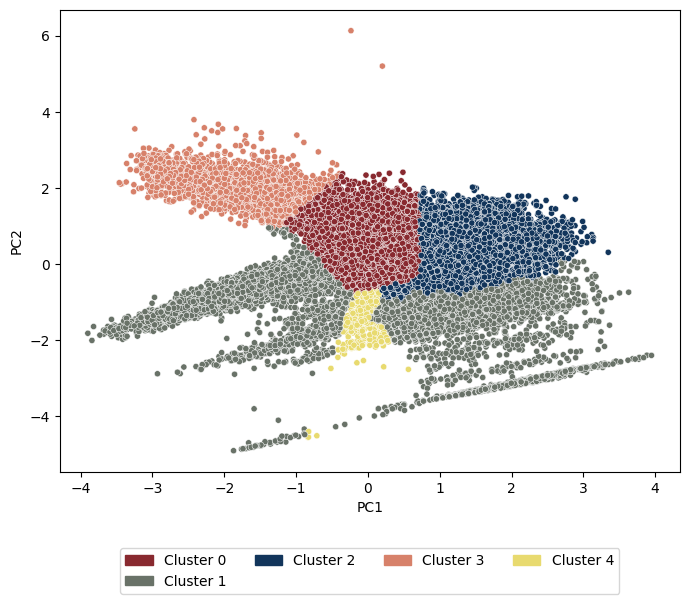

In [38]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title("Ensemble CLARA and Ward's Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_ward_clara)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [39]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,1
1,0.203757,-1.467581,11,1
2,1.005381,-1.059952,11,1
3,2.111048,-0.849120,11,1
4,-0.148070,-1.640123,11,1


In [40]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,1
1,12,1.826629,-1.419172,1
2,13,-0.754270,0.041137,1
3,14,0.939960,0.034637,1
4,15,-0.538450,-0.000517,1
...,...,...,...,...
72,510,0.211749,0.019254,3
73,511,0.800390,0.061607,3
74,512,2.197902,-3.128753,3
75,513,-2.400037,2.145315,3


In [41]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [26, 27, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 57, 62, 65, 66, 67, 69, 70, 71]
Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 68]
Cluster 2: [9]
Cluster 3: [72, 73, 74, 75, 76]


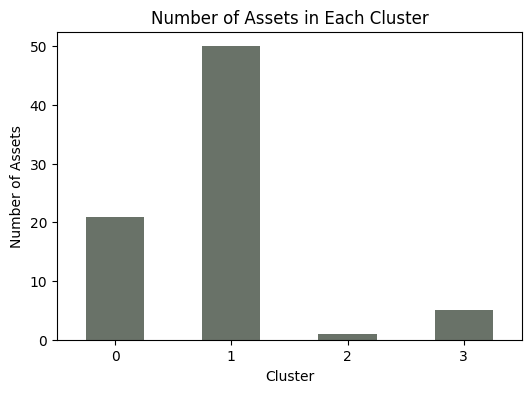

In [42]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [43]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_ward_clara)
results.append({'Model': 'ward + clara', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [44]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,-0.089707,21.078087,237.516042,0.000010,0.000024
1,clara + kmeans,-0.138677,16.197900,225.774162,0.000015,0.000024
2,ward + clara,-0.091044,24.655623,249.945564,0.000015,0.000024


## ward + K-Means + CLARA

In [45]:
df = df[['PC1', 'PC2']]

In [46]:
voting_labels_all = np.zeros(len(df), dtype=int)

for i in range(len(df)):
    kmeans_cluster = kmeans_labels[i]
    ward_cluster = ward_labels[i]
    clara_cluster = clara_labels[i]
    
    # Create a voting array
    votes = np.zeros(num_clusters, dtype=int)
    votes[kmeans_cluster] += 1
    votes[ward_cluster] += 1
    votes[clara_cluster] += 1
    
    # Assign the data point to the cluster with the most votes
    voting_labels_all[i] = np.argmax(votes)

print('Voting based method is done')

Voting based method is done


In [47]:
df['cluster_label'] = voting_labels_all
df['asset_id'] = subset_df['asset_id']

In [48]:
df.to_csv('results/raw_solar/clara_kmeans_ward.csv', index = False)

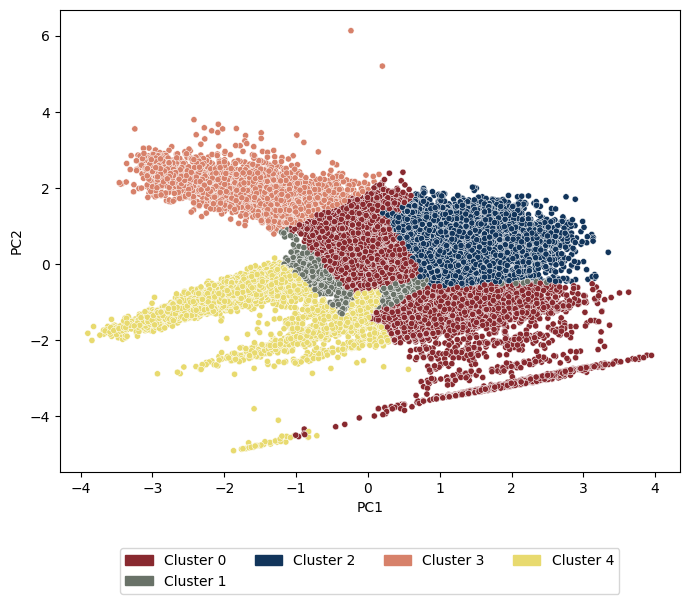

In [49]:
n_clusters = len(df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
# plt.title('Ensemble K-Means, CLARA and Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(voting_labels_all)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [50]:
most_frequent_clusters = df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df = df.drop(columns= 'cluster_label')

df = pd.merge(df, most_frequent_clusters, on='asset_id', how='left')

df.head()

,PC1,PC2,asset_id,cluster_label
0,1.073620,-2.073383,11,0
1,0.203757,-1.467581,11,0
2,1.005381,-1.059952,11,0
3,2.111048,-0.849120,11,0
4,-0.148070,-1.640123,11,0


In [51]:
representative_points = df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,1.073620,-2.073383,0
1,12,1.826629,-1.419172,0
2,13,-0.754270,0.041137,4
3,14,0.939960,0.034637,4
4,15,-0.538450,-0.000517,4
...,...,...,...,...
72,510,0.211749,0.019254,3
73,511,0.800390,0.061607,3
74,512,2.197902,-3.128753,3
75,513,-2.400037,2.145315,3


In [52]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 47, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [9, 10, 11, 12, 13, 15, 16, 36, 37, 38, 40, 45, 46, 48, 49, 50, 51, 53, 54, 55]
Cluster 3: [39, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 4: [2, 3, 4, 5, 14, 17, 33]


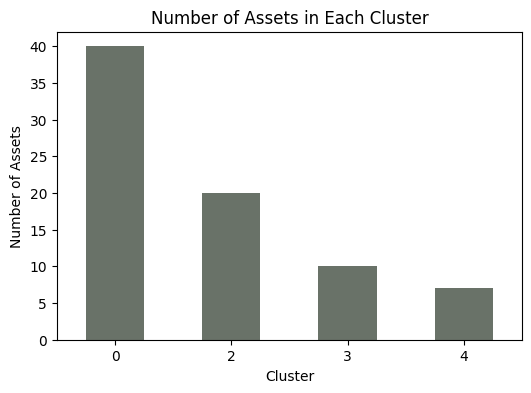

In [53]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Metrics

In [54]:
# Compute and store the evaluation metrics for each dataframe
metrics = compute_metrics(labels=voting_labels_all)
results.append({'Model': 'clara + kmeans + ward', **metrics})

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

In [55]:
results_df

,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Dunn Index,Xie-Beni Index
0,ward + kmeans_opt,-0.089707,21.078087,237.516042,0.000010,0.000024
1,clara + kmeans,-0.138677,16.197900,225.774162,0.000015,0.000024
2,ward + clara,-0.091044,24.655623,249.945564,0.000015,0.000024
3,clara + kmeans + ward,-0.085827,47.205309,227.486544,0.000010,0.000024


In [56]:
with open('results/raw_solar/results.pickle', 'wb') as f:
    pickle.dump(results,f)

results_df.to_csv('results/raw_solar/results.csv', index=False)

In [57]:
normalized_df = results_df.copy()

# Define ideal and anti-ideal solutions for each metric
ideal_solution = normalized_df.copy()
anti_ideal_solution = normalized_df.copy()

# Define metrics where higher values are better
higher_is_better = ['Silhouette Score', 'Dunn Index', 'Calinski-Harabasz Index']

# Define metrics where lower values are better
lower_is_better = ['Davies-Bouldin Index', 'Xie-Beni Index']

# Set ideal and anti-ideal solutions for metrics where higher values are better
for metric in higher_is_better:
    ideal_solution[metric] = normalized_df[metric].max()
    anti_ideal_solution[metric] = normalized_df[metric].min()

# Set ideal and anti-ideal solutions for metrics where lower values are better
for metric in lower_is_better:
    ideal_solution[metric] = normalized_df[metric].min()
    anti_ideal_solution[metric] = normalized_df[metric].max()

# Calculate the distance from each alternative to the ideal and anti-ideal solutions
dist_to_ideal = ((normalized_df.iloc[:,1:] - ideal_solution) ** 2).sum(axis=1) ** 0.5
dist_to_anti_ideal = ((normalized_df.iloc[:,1:] - anti_ideal_solution) ** 2).sum(axis=1) ** 0.5

# Calculate the relative closeness to the ideal solution --> the one that has the bigger distance from the anti-ideal solution is the one thats closer to the ideal solution
normalized_df['Closeness'] = dist_to_anti_ideal / (dist_to_ideal + dist_to_anti_ideal)

# Sort the models based on their relative closeness to the ideal solution
ranked_models = normalized_df.sort_values(by='Closeness', ascending=False)

# Print the ranked models
ranked_models[['Model', 'Closeness']]

,Model,Closeness
2,ward + clara,0.796270
0,ward + kmeans_opt,0.682048
1,clara + kmeans,0.561944
3,clara + kmeans + ward,0.042830
